In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

In [10]:
df_2 = pd.read_csv('randomForest2.csv')
df_4 = pd.read_csv('randomForest4.csv')
df_6 = pd.read_csv('randomForest6.csv')
df_8 = pd.read_csv('randomForest8.csv')

In [12]:
def parse_simul_df(df):
    df = df[df['Module'].str.contains("appl")]
    important_attrs = ['Module','Name','Unnamed: 18','runattr:iterationvarsf']
    df = df[important_attrs]
    run_attrs_dict = defaultdict(list)
    for run_attrs in df['runattr:iterationvarsf']:
        run_attrs_arr = run_attrs.split(',')
        run_attrs_dict['expected_reliability'].append(run_attrs_arr[0])
        run_attrs_dict['computation_task'].append(run_attrs_arr[1])
        run_attrs_dict['replication_factor'].append(run_attrs_arr[2][:len(run_attrs_arr[2])-1])
    run_attrs_df = pd.DataFrame(run_attrs_dict,index=df.index)
    final_df = pd.concat([df,run_attrs_df],axis=1,sort=False)
    return final_df

In [18]:
dfs = [df_2,df_4,df_6,df_8]

In [19]:
for df in dfs:
    df = parse_simul_df(df)

In [28]:
def plot_replication_factor(df,title):
    er_values = df['expected_reliability'].unique()
    ct_values = df['computation_task'].unique()
    rf_values = df['replication_factor'].unique()
    lb = df[df.Name=='Load Balancer : 2 work finished']
    rf1,rf2,index = [],[],[]
    for ct in ct_values:
        for er in er_values:
            index.append("{},{}".format(ct,er))          
            for rf in rf_values:
                tmp_df = lb[(lb.replication_factor==rf) & (lb.expected_reliability==er) & (lb.computation_task ==ct)] 
                parsed_series =  tmp_df['Unnamed: 18']
                if rf=='1':
                    rf1.append(parsed_series[parsed_series.first_valid_index()])
                else:
                    rf2.append(parsed_series[parsed_series.first_valid_index()])
    rf_df = pd.DataFrame({'replication factor of 1':rf1,'replication factor of 2':rf2},index=index)
    ax =rf_df.plot.bar(rot=0)
    ax.set_title(title)
    plt.show()

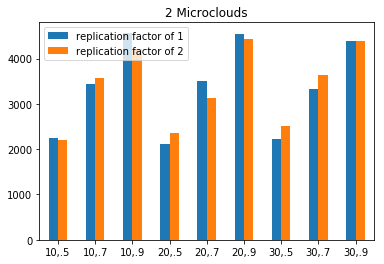

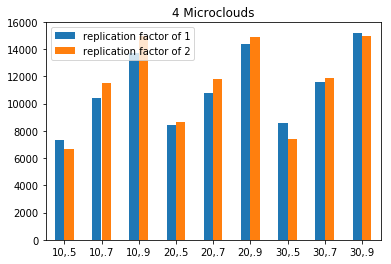

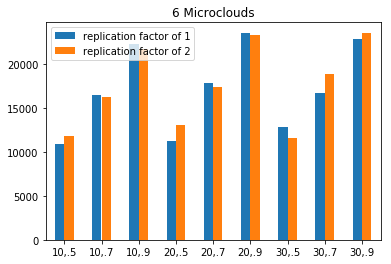

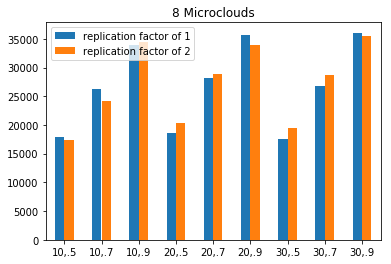

In [32]:
num_mcs_arr = []
num_mc_to_df = {}
num_mcs = 2
for df in dfs:
    plot_replication_factor(df,str(num_mcs)+" Microclouds")
    num_mc_to_df[num_mcs] = df
    num_mcs_arr.append(num_mcs)
    num_mcs+=2

In [35]:
def plot_work_to_num_mcs(num_mc_to_df,num_mcs_arr):
    example_df = num_mc_to_df[num_mcs_arr[0]]
    er_values = example_df['expected_reliability'].unique()
    ct_values = example_df['computation_task'].unique()
    rf_values = df['replication_factor'].unique()
    for rf in rf_values:
        for er in er_values:
            for ct in ct_values:
                work = []
                for num_mcs in num_mcs_arr:
                    tmp_df = num_mc_to_df[num_mcs]
                    tmp_df = tmp_df[tmp_df.Name=='Load Balancer : 2 work finished']
                    tmp_df = tmp_df[(tmp_df.replication_factor==rf) & (tmp_df.computation_task==ct) &(tmp_df.expected_reliability==er)]
                    parsed_series =  tmp_df['Unnamed: 18']
                    work.append(parsed_series[parsed_series.first_valid_index()])
                plt.plot(num_mcs_arr,work,label="Computation task {}".format(ct))
            plt.xlabel("Number of microclouds")
            plt.ylabel("Work units completed")
            plt.title("Work completed with reliability {} and replication factor {}".format(er,rf))
            plt.legend(loc="best")
            plt.show()

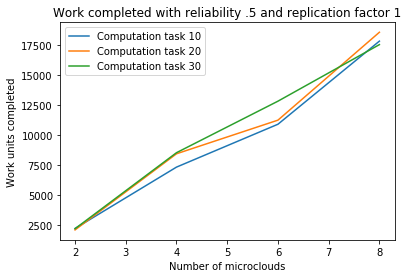

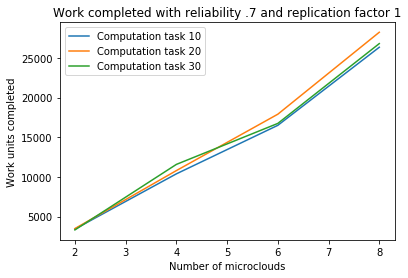

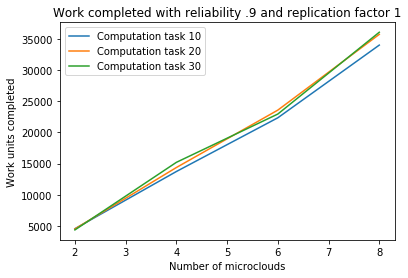

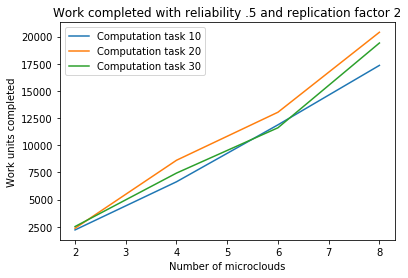

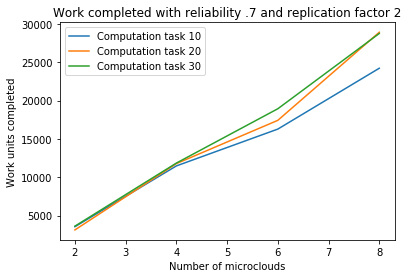

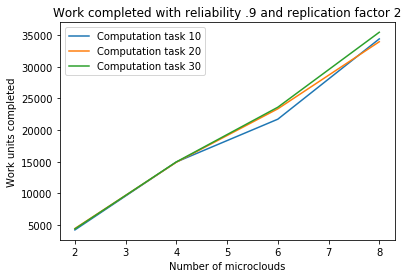

In [36]:
plot_work_to_num_mcs(num_mc_to_df,num_mcs_arr)